# Применение нейронных сетей для ускорения метода Якоби

Здесь мы попытаемся применить нейронные сети, чтобы ускорить метод Якоби.

## Генерация датасета

Множество решаемых уравнений:

$$
        \Delta u = g(x), 
$$
$$
        u(x) = f(x), \quad x \in \partial G.
$$

Пусть $G$ --- квадрат $[0, 1] \times [0, 1]$. Рассмотрим одну из его четырех сторон, назовем ее $l_1 = \{0\} \times [0,1]$. Сгенерируем $n$ случайных значений от 0 до 1 и отсортируем их, получим набор $a_1, \ldots, a_n$, $a_0 = 0$, $a_{n+1} = 1$. После сгенерируем $n+1$ значение из отрезка $[-1, 1]$, получим набор $b_0, \ldots, b_n$. Точкам $a_i$ можно однозначно сопоставить точки на $l_1$, а $a_0$ и $a_{n+1}$ отождествить с ее концами. В таком случае, запишем:
    
$$
    u(x) = T + b_i, \quad x \in \{0\} \times [a_i, a_{i+1}].
$$
Аналогично поступим с остальными сторонами квадрата.

Для генерации различных функций $g(x)$ воспользуемся тем фактом, что средние Рисса сходятся равномерно, т.е.

$$
g(x) \approx \sum_{|n| < \mu} \left (1 - \frac{|n|^2}{\mu^2} \right)^s (a_n sin(2 \pi n \cdot x) + b_n cos(2 \pi n \cdot x)), \quad s > \frac{1}{2}.
$$

Возможно, это не оптимальный вариант перебора. Общая его идея основывается на том, чтобы перебрать различные аппроксимации. Про средние Рисса известно, что они сходятся равномерно, но скорость сходимости мне найти не удалось. Подробности в Overleaf'e. 

Числа $a_n$ и $b_n$ будем семплировать из $U[-1, 1]$.

Запишем генерацию на сетке:

$$
g_{ij}^{(m)} = \sum_{p = - \mu}^{\mu} \sum_{k = -\mu}^{\mu} \left (1 - \frac{p^2 + k^2}{\mu^2} \right)^s  \left ( a_{pk}^{(m)} sin(2 \pi (p x_i + k y_j)) + b_{pk}^{(m)}cos(2 \pi (p x_i + k y_j)) \right ) I\{p^ 2 + k^2 < \mu^2\},
$$

где $m$ --- номер семпла. Возможно, что множитель не несет смысла --- ведь $a_n$ и $b_n$ случайны, и он задает только их убывание, что можно было бы сделать другим способом.

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sps
import seaborn as sns
from tqdm.notebook import tqdm
from time import time
import json
import os

sns.set(font_scale=1.4)

In [0]:
class DatasetGenerator:

    def __init__(self, N):
        self.N = N

    def sample_init_conditionals_(self, sample_size):
        """
        Генерирует sample_size начальных условий
        """
        n = 20
        limits = sps.uniform.rvs(size=(sample_size * 4, n))
        limits = (np.sort(limits, axis=1) * (self.N + 1))
        limits = limits.astype(np.int)
        repeats = np.hstack((
            limits[:, 0].reshape(-1, 1),
            limits[:, 1:] - limits[:, :-1],
            ((self.N + 1) - limits[:, -1]).reshape(-1, 1)
        ))


        values = sps.uniform(loc=-1, scale=2).rvs(size=(sample_size * 4, n + 1))
        # дадим случайный подогорев каждой из сторон
        # чтобы темепарутра в центре не равна 0
        T = sps.uniform(loc=-1, scale=2).rvs(size=(sample_size * 4))
        values = T.reshape(-1, 1) + values

        self.init_condtionals_ = np.repeat(
            values.flatten(), 
            repeats.flatten()
            ).reshape(sample_size, 4, self.N + 1)


    def sample_f_(self, sample_size):
        """
        Генерирует sample_size правых частей
        """
        x = np.linspace(0, 1, self.N - 1).repeat(self.N - 1)
        y = np.linspace(0, 1, self.N - 1).reshape(1, -1)
        y = y.repeat(self.N - 1, axis=0).flatten()
        X = np.hstack((
            x.reshape(-1, 1),
            y.reshape(-1, 1)
        ))

        assert X.shape == ((self.N - 1) ** 2, 2), "Неверные размеры"

        mu = 10
        amount = 2 * mu + 1
        p = np.arange(-mu, mu + 1).repeat(amount)
        k = np.arange(-mu, mu + 1).reshape(1, -1)
        k = k.repeat(amount, axis=0).flatten()
        Z = np.hstack((
            p.reshape(-1, 1),
            k.reshape(-1, 1)
        ))

        assert Z.shape == (amount ** 2, 2), "Неверные размеры"

        # p = [-mu, ..., 0, ..., mu]
        # x = [0, h, 2 h, ..., 1]
        # Arg[i, j] = 2 \pi (p[i // amount] * x[j // (self.N - 1)] + 
        # + p[i % amount] * x[j % (self.N - 1)])
        Arg = 2 * np.pi * Z @ X.T

        sq_sum = p ** 2 + k ** 2

        cos = np.cos(Arg)
        sin = np.sin(Arg)

        a = sps.uniform(loc=-1, scale=2).rvs(size=(sample_size, amount ** 2))
        b = sps.uniform(loc=-1, scale=2).rvs(size=(sample_size, amount ** 2))
        
        s = 4 / 7
        factor = ((1 - sq_sum / mu ** 2) * (sq_sum < mu ** 2)) ** s
        a = a * factor
        b = b * factor

        f = a @ cos + b @ sin
        f = f.reshape(sample_size, self.N - 1, self.N -1)
        return f
        



    def __call__(self, num_sample=500, batch_size=100, dir="", save=True):
        """
        Генерирует датасет и сохраняет батчи в директорию
        num_samples --- количество элементов датасета
        batch_size ---  размер батча
        dir --- директория датасета
        """
        assert num_sample % batch_size == 0, "Некорректный размер батча"

        labels_file_name = os.path.join(dir, 'labels.json')
        try:
            with open(labels_file_name, 'r') as labels_file:
                labels = json.load(labels_file)
        except FileNotFoundError:
            labels = []


        for i in tqdm(range(num_sample // batch_size)):
            current_time = time()
            labels.append(current_time)
            u = np.zeros((batch_size, self.N + 1, self.N + 1))
            self.sample_init_conditionals_(batch_size)
            u[:, :, 0] = self.init_condtionals_[:, 0, :]
            u[:, 0, :] = self.init_condtionals_[:, 1, :]
            u[:, :, -1] = self.init_condtionals_[:, 2, :]
            u[:, -1, :] = self.init_condtionals_[:, 3, :]

            h = 1.0/self.N
            max_it = self.N ** 2
            x = np.arange(self.N+1) * h # x = i * h, i = 0,...,N
            y = np.arange(self.N+1) * h # y = j * h, j = 0,...,N

            # согласно Деммелю, это примерное количество итераций
            # для получения адекватной неувязки
            max_it = self.N ** 2
            history = np.zeros(
                (batch_size, 
                max_it // self.N, self.N + 1, 
                self.N + 1)
                )
            
            x_index = np.repeat(np.arange(1, self.N)[:, np.newaxis], 
                                self.N-1, axis=1)
            y_index = np.repeat(np.arange(1, self.N)[np.newaxis, :], 
                                self.N-1, axis=0)
            f = self.sample_f_(batch_size)

            np.save(os.path.join(dir, f'init_cond_{current_time}'),
                    self.init_condtionals_)
            np.save(os.path.join(dir, f'right_side_{current_time}'), f)
            
            for j in tqdm(range(max_it)):
                u[:, x_index, y_index] = 0.25 * (u[:, x_index + 1, y_index] + 
                                        u[:, x_index - 1, y_index] + 
                                        u[:, x_index, y_index + 1] + 
                                        u[:, x_index, y_index - 1] - h ** 2 * f)
                if (j % self.N == 0):
                    history[:, j // self.N] = u
            
            # посмотрим неувязку для первого уравнения
            u_new = u[-1].copy()
            delta = u_new[x_index, y_index] -\
                                 0.25 * (u_new[x_index + 1, y_index] + 
                                        u_new[x_index - 1, y_index] + 
                                        u_new[x_index, y_index + 1] + 
                                        u_new[x_index, y_index - 1] - 
                                       h ** 2 * f[-1])
            self.log_delta = np.log(np.max(np.abs(delta)) / np.max(np.abs(u_new)))
            
            np.save(os.path.join(dir, f'solution_{current_time}'), u)
            np.save(os.path.join(dir, f'history_{current_time}'), history)

            # сохраним времена создания данных
            if (save):
                with open(labels_file_name, 'w') as labels_file:
                    json.dump(labels, labels_file)
        # возвратим последнее значение
        return u[-1]

    def load(self, dir="", load_history=False):
        labels_file_name = os.path.join(dir, 'labels.json')
        with open(labels_file_name, 'r') as labels_file:
            labels = json.load(labels_file)

        result = dict()
        for label in labels:
            solution_path = os.path.join(dir, f'solution_{label}.npy')
            init_conditionals_path =\
                    os.path.join(dir, f'init_cond_{label}.npy')
            right_side_path = \
                    os.path.join(dir, f'right_side_{label}.npy')
            
            if (load_history):
                history_path = os.path.join(dir, f'history_{label}.npy')


            result['solution'] = np.load(solution_path, allow_pickle=True)
            result['init_condtionals'] = np.load(init_conditionals_path,
                                                 allow_pickle=True)
            result['right_side'] = np.load(right_side_path, allow_pickle=True)
            
            if (load_history):
                result['history'] = np.load(history_path, allow_pickle=True)

            self.N = result['solution'].shape[-1] - 1

            yield result
        



In [0]:
N = 100
dg = DatasetGenerator(N)

Посмотрим на слуйчайно сгенерированную функцию $g$:

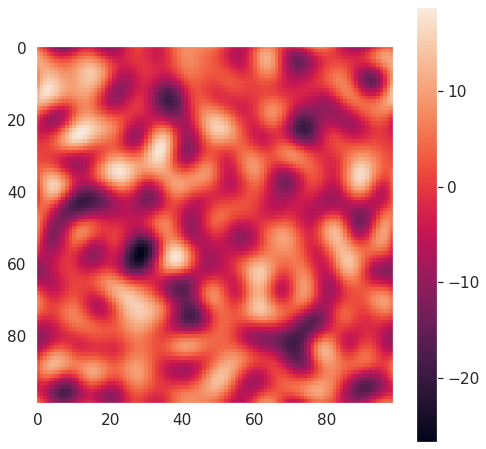

In [0]:
f  = dg.sample_f_(1)[0]

fig = plt.figure(figsize=(8, 8))
im = plt.imshow(f)
fig.colorbar(im)
plt.grid(False)
plt.show()

Видно, что она вполне гладкая и случайная, однако остается вопрос, научится ли наш солвер решать здачи для более "однородных" $g$.

Проверим корректность работы алгоритма:

In [0]:
result = dg(num_sample=2, batch_size=2, save=False)

In [0]:
print("Логарифм невязки:", dg.log_delta / np.log(10))

Логарифм неувязки: -7.026925335836878


Вполне адекватное значение. Посмотрим на одно из решений.

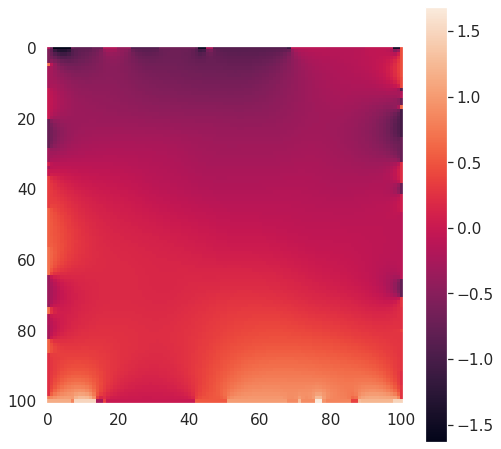

In [0]:
fig = plt.figure(figsize=(8, 8))
im = plt.imshow(result)
fig.colorbar(im)
plt.grid(False)
plt.show()

Теперь приступим к генерации.

In [0]:
dg(num_sample=1000, batch_size=1000, 
   dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data");

## Поиск решения методами машинного обучения

### UMAP и простые нейронные сети

Попробуем решить задачу тривиальным способом. Возьмем начальные условия, переведем правую часть уравнения Пуассона в вектор размера N + 1 или еще меньше, распрямим. Помним, что мы хотим достичь точности $10^{-6}$.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from umap import UMAP
from sklearn.decomposition import PCA

from time import time

Пока возьмем небольшой датасет из сгенированных нами (1250 различных задач), разобьем его на тренировочную и тестовую выборки.

In [0]:
class TransformData:

    def __init__(self, N, neighbors_ic=15, neighbors_u=15):
        """
        N --- размер сетки
        neighbors_ic --- количество соседей для UMAP в случае граничных условий
        neighbors_u --- количетсво соседей для UMAP в случае решения u
        pow --- степень, в формуле снижения размерности для u 
        """
        
        self.umap_transformer_ic = UMAP(
            n_neighbors=neighbors_ic,
            n_components=N // 2
        )

        # количество параметров для mu=10 есть 171
        # возьмем 200
        self.pca_transformer_g = PCA(
            n_components=171
        )

        # наугад взятая размерность
        # мы знаем, что u однозначно задается 2N + 171 параметром,
        # но на нам следует взять лишнего
        # и в будущем попробовать автоэнкодер
        self.pca_inverse = PCA(
            n_components=int(N ** 1.5)
        )

    def target_transform(self, solution):
        y = self.pca_inverse.transform(
            solution.reshape(solution.shape[0], -1)
        )
        y = torch.from_numpy(y)
        return y


    def fit_transform(self, init_cond, right_side, solution):
        """
        init_cond --- начальные условия
        right_side --- правая часть
        solution --- решение
        """

        print("Обучение преобразования снижения размерности для начальных условий...")
        init_cond_trsfmed = self.umap_transformer_ic.fit_transform(
            init_cond.reshape(-1, init_cond.shape[-1])
        )
        init_cond_trsfmed = init_cond_trsfmed.reshape(right_side.shape[0], -1)

        print("Обучение преобразования снижения размерности для правой части...")
        right_side_trsfmed = self.pca_transformer_g.fit_transform(
            right_side.reshape(right_side.shape[0], -1)
        )

        X = np.hstack((
            init_cond_trsfmed,
            right_side_trsfmed
        ))

        X = torch.from_numpy(X)

        print("Обучение преобразования снижения размерности для решения...")
        y = self.pca_inverse.fit_transform(
            solution.reshape(solution.shape[0], -1)
        )

        y = torch.from_numpy(y)

        return X, y

    def forward_transform(self, init_cond, right_side):
        """
        init_cond --- начальные условия
        right_side --- правая часть
        """

        print('Снижаю размерность начальных условий...')
        init_cond_trsfmed = self.umap_transformer_ic.transform(
            init_cond.reshape(-1, init_cond.shape[-1])
        )
        init_cond_trsfmed = init_cond_trsfmed.reshape(right_side.shape[0], -1)

        print('Снижаю размерность правой части...')
        right_side_trsfmed = self.pca_transformer_g.transform(
            right_side.reshape(right_side.shape[0], -1)
        )

        X = np.hstack((
            init_cond_trsfmed,
            right_side_trsfmed
        ))

        X = torch.from_numpy(X)

        return X


    def reverse_transform(self, solution_trsfmed):

        y = solution_trsfmed.detach().numpy()

        result = self.pca_inverse.inverse_transform(y)

        side = int(np.sqrt(result.shape[1]))

        result = result.reshape(-1, side, side)

        return result

In [0]:
class DataLoader:

    def __init__(self, dir="", batch_size=50):
        self.dir = dir
        self.generator = DatasetGenerator(-1)
        self.batch_size = batch_size

    def __call__(self, transformer):
        for data in self.generator.load(self.dir):
            sample_size = data['solution'].shape[0]

            X = transformer.forward_transform(
                data['init_condtionals'],
                data['right_side']
            )

            y = transformer.target_transform(
                data['solution']
            )

            for t in np.arange(0, sample_size, self.batch_size):
                result =  (X[t:t + self.batch_size], y[t:t + self.batch_size])
                yield result


data_loader = DataLoader(
    dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data"
)

In [0]:
data = next(dg.load(
     dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data"
))

data_transformer = TransformData(N)
data_transformer.fit_transform(
    data['init_condtionals'],
    data['right_side'],
    data['solution']
);

Обучение преобразования снижения размерности для начальных условий...
Обучение преобразования снижения размерности для правой части...
Обучение преобразования снижения размерности для решения...


Проверим, что размерность восстанавливается корректно:

In [0]:
u = data_transformer.reverse_transform(y[150].reshape(1, -1))[0]

Невязка: 1.4771319383334605e-14


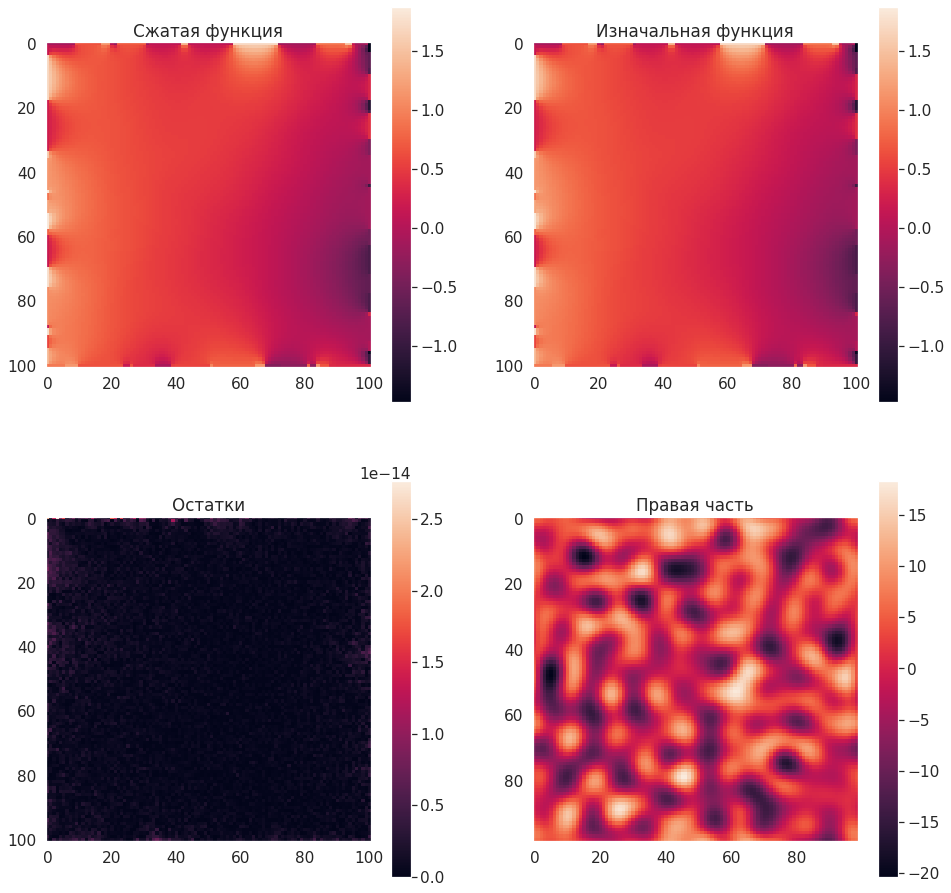

In [0]:
fig = plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
im = plt.imshow(u)
plt.colorbar(im)
plt.grid(False)
plt.title('Сжатая функция')

plt.subplot(2, 2, 2)
im = plt.imshow(data['solution'][150])
plt.colorbar(im)
plt.grid(False)
plt.title('Изначальная функция')

plt.subplot(2, 2, 3)
im = plt.imshow(np.abs(data['solution'][150] - u))
plt.colorbar(im)
plt.grid(False)
plt.title('Остатки')

plt.subplot(2, 2, 4)
im = plt.imshow(data['right_side'][0])
plt.colorbar(im)
plt.grid(False)
plt.title('Правая часть')

print('Невязка:', \
      np.max(np.abs(data['solution'][150] - u)) / 
      np.max(np.abs(data['solution'][150])))
plt.show()

Как видим, невязка оказалось очень маленькой (в сравнении с тем, какую точность дает метод Якоби в нашем случае). Стоит заметить, что если взять показатель степени хотя бы 1.4, то невязка возрастает до $10^{-3}$.

In [0]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [0]:
hidden_layer_size = 150
learning_rate = 1e-2

In [0]:
model = nn.Sequential(
    nn.Linear(N * 2 + 171, 400),
    nn.ReLU(),
    nn.Linear(400, 500),
    nn.Linear(500, 600),
    nn.ReLU(),
    nn.Linear(600, int(N ** 1.5))
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [0]:
def train(model, optimizer, epochs=1):
    """
    Train a model on dataset using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss = nn.MSELoss()
    for e in tqdm(range(epochs)):
        generator = data_loader(data_transformer)
        for x, y in generator:
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            scores = model(x)
            output = loss(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            output.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

In [0]:
train(model, optimizer, epochs=100)

1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...
Снижаю размерность правой части...
1000
Снижаю размерность начальных условий...


KeyboardInterrupt: ignored

In [0]:
def solver(init_cond, right_side):
    output = data_transformer.forward_transform(init_cond, right_side)
    output = output.to(device=device, dtype=dtype)
    output = model(output)
    output = torch.Tensor.cpu(output)
    output = data_transformer.reverse_transform(output)
    output[:, :, 0] = init_cond[:, 0, :]
    output[:, 0, :] = init_cond[:, 1, :]
    output[:, :, -1] = init_cond[:, 2, :]
    output[:, -1, :] = init_cond[:, 3, :]
    return output

In [0]:
result = solver(data['init_condtionals'], data['right_side'])

Снижаю размерность начальных условий...
Снижаю размерность правой части...


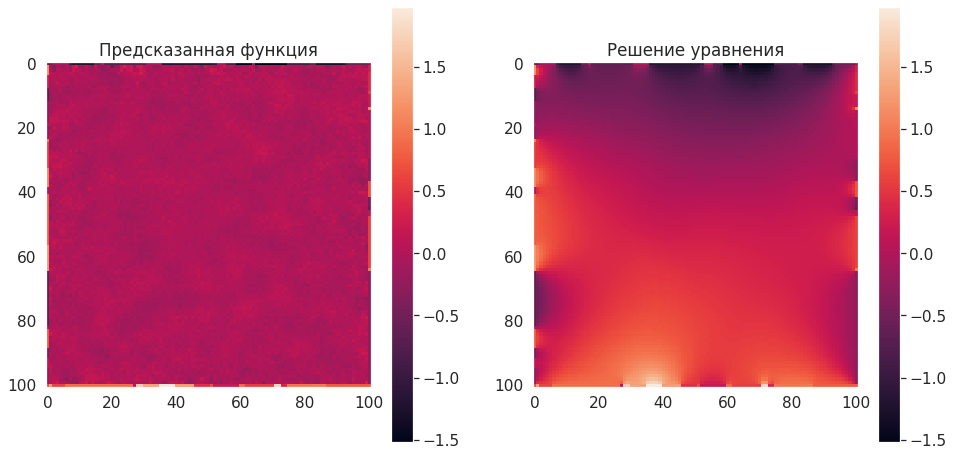

In [0]:
fig = plt.figure(figsize=(16, 8))
i = 400
plt.subplot(1, 2, 1)
im = plt.imshow(result[i])
plt.colorbar(im)
plt.grid(False)
plt.title('Предсказанная функция')

plt.subplot(1, 2, 2)
im = plt.imshow(data['solution'][i])
plt.colorbar(im)
plt.grid(False)
plt.title('Решение уравнения')
plt.show()

Как мы видим, качество оставляет желать лучшего. Посмотрим, смогли ли мы ускорить сходимость метода Якоби:

In [0]:
def solve_poisson(u, f):
    N = u.shape[0] - 1
    x_index = np.repeat(np.arange(1, self.N)[:, np.newaxis], 
                                self.N-1, axis=1)
    y_index = np.repeat(np.arange(1, self.N)[np.newaxis, :], 
                        self.N-1, axis=0)
    
    while True:
        u_new = u.copy()
        u_new[x_index, y_index] = 0.25 * (u[x_index + 1, y_index] + 
                                        u[x_index - 1, y_index] + 
                                        u[x_index, y_index + 1] + 
                                        u[x_index, y_index - 1] - h ** 2 * f)
        delta = np.max(np.abs(u_new - u)) / np.max(np.abs(u))
        u = u_new

        if (delta < 1e-6):
            break
    return u

In [0]:
def NN_solver(init_cond, right_side):
    output = solver(init_cond.reshape(1, *init_cond.shape),
                    right_side.reshape(1, *right_side.shape))[0]
    output = solve_poisson(output, right_side[0])
    return output

def Jacobi_solver(init_cond, right_side):
    N = init_cond.shape[0] - 1
    output = np.zeros((N + 1, N + 1))
    output[:, 0] = init_cond[0, :]
    output[0, :] = init_cond[1, :]
    output[:, -1] = init_cond[2, :]
    output[-1, :] = init_cond[3, :]
    return solve_poisson(output, right_side)

In [0]:
dg(num_sample=100, batch_size=100, 
   dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data/test");

test_data = next(
    dg.load(dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data/test")
)

In [0]:
time_nn = []
time_jacobi = []

for i in range(10):
    init_cond = data['init_cond'][i]
    right_side = data['right_side'][i]

    begin_time = time()
    NN_solver(init_cond, right_side)
    end_time = time()

    time_nn.append(end_time - begin_time)

    begin_time = time()
    Jacobi_solver(init_cond, right_side)
    end_time = time()

    time_jacobi.append(end_time - begin_time)

print('Среднее время работы с нейросетями:', np.mean(time_nn))
print('Среднее время работы методя Якоби:', np.mean(time_jacobi))